# Movie Reccomendation System with Rating prediction

In [3]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
#import needed packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# **Movie Reccomendation**

In [ ]:
#define paths
path = "/content/drive/MyDrive/Colab Notebooks/recommendation system/"

In [ ]:
#import datasets
credits_df = pd.read_csv(path + 'Dataset/tmdb_5000_credits.csv')
movies_df = pd.read_csv(path + 'Dataset/tmdb_5000_movies.csv')

In [ ]:
#checking credit df...
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
credits_df.isna().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

In [ ]:
credits_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movie_id,4803.0,57165.484281,88694.614033,5.0,9014.5,14629.0,58610.5,459488.0


In [ ]:
#checking movies df...
movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
movies_df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [ ]:
#dropping homepage and tagline as they have a massive ammount of missing values
movies_df = movies_df.drop(columns=['homepage', 'tagline'])
movies_df.isna().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                3
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [ ]:
movies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4803.0,2.904504e+07,4.072239e+07,0.0,790000.00000,1.500000e+07,4.000000e+07,3.800000e+08
id,4803.0,5.716548e+04,8.869461e+04,5.0,9014.50000,1.462900e+04,5.861050e+04,4.594880e+05
popularity,4803.0,2.149230e+01,3.181665e+01,0.0,4.66807,1.292159e+01,2.831350e+01,8.755813e+02
revenue,4803.0,8.226064e+07,1.628571e+08,0.0,0.00000,1.917000e+07,9.291719e+07,2.787965e+09
runtime,4801.0,1.068759e+02,2.261193e+01,0.0,94.00000,1.030000e+02,1.180000e+02,3.380000e+02
vote_average,4803.0,6.092172e+00,1.194612e+00,0.0,5.60000,6.200000e+00,6.800000e+00,1.000000e+01
vote_count,4803.0,6.902180e+02,1.234586e+03,0.0,54.00000,2.350000e+02,7.370000e+02,1.375200e+04


In [ ]:

#renamed credits datasets movie_id to id 
#marging credit and movie dataset on id 
credits_df.columns = ['id','tittle','cast','crew']
movies_df= credits_df.merge(movies_df,on='id')
tmdb_df = movies_df.copy()

In [ ]:
#checking...
movies_df.head()

,id,tittle,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124


In [ ]:
#convert Json into strings and later into lists

def JsonToString(dataframe,column_name):
  dataframe[column_name] = dataframe[column_name].apply(json.loads)
  for index,i in zip(dataframe.index,dataframe[column_name]):
    list1 = []
    for j in range(len(i)):
      list1.append((i[j]['name'])) # "Name" contains the name of the genre
    dataframe.loc[index,column_name] = str(list1)

In [ ]:
#calling the function
JsonToString(movies_df, 'cast')
JsonToString(movies_df, 'genres')
JsonToString(movies_df, 'keywords')
JsonToString(movies_df, 'production_companies')
JsonToString(movies_df, 'production_countries')
JsonToString(movies_df, 'spoken_languages')

In [ ]:
#checking...
movies_df.head()

,id,tittle,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...","['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2009-12-10,2787965087,162.0,"['English', 'Español']",Released,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"['Adventure', 'Fantasy', 'Action']","['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],2007-05-19,961000000,169.0,['English'],Released,Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"['Action', 'Adventure', 'Crime']","['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",2015-10-26,880674609,148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"['Christian Bale', 'Michael Caine', 'Gary Oldm...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"['Action', 'Crime', 'Drama', 'Thriller']","['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],2012-07-16,1084939099,165.0,['English'],Released,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"['Action', 'Adventure', 'Science Fiction']","['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],['United States of America'],2012-03-07,284139100,132.0,['English'],Released,John Carter,6.1,2124


In [ ]:
#clean up commas from column
def cleanUpColumn(dataframe, column_name):
  dataframe[column_name] = dataframe[column_name].str.strip('[]').str.replace(' ','').str.replace("'",'')
  dataframe[column_name] = dataframe[column_name].str.split(',')
  return dataframe

In [ ]:
#unique features function
def uniqueFeatures(dataframe,feature_name):
  List = []
  for index, row in dataframe.iterrows():
    features = row[feature_name]
    for feature in features:
      if feature not in List:
        List.append(feature)
  return List[:15]

In [ ]:
#binary encoding
def binary(genre_list,list):
    binaryList = []
    
    for genre in list:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
#sorting in list 
def sortwords(dataframe,columnName,numberofwords):
  for i,j in zip(dataframe[columnName],dataframe.index):
    list2=[]
    list2=i[:numberofwords]
    list2.sort()
    dataframe.loc[j,columnName]=str(list2)
  dataframe[columnName]=dataframe[columnName].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
  dataframe[columnName]=dataframe[columnName].str.split(',')
  return dataframe[columnName]


**Genres**

In [ ]:
#genres column cleaning
movies_df=cleanUpColumn(movies_df,"genres")

In [ ]:
movies_df.genres

0       [Action, Adventure, Fantasy, ScienceFiction]
1                       [Adventure, Fantasy, Action]
2                         [Action, Adventure, Crime]
3                   [Action, Crime, Drama, Thriller]
4                [Action, Adventure, ScienceFiction]
                            ...                     
4798                       [Action, Crime, Thriller]
4799                               [Comedy, Romance]
4800               [Comedy, Drama, Romance, TVMovie]
4801                                              []
4802                                   [Documentary]
Name: genres, Length: 4803, dtype: object

In [ ]:
#get the unique values for genre
List = uniqueFeatures(movies_df,"genres")

In [ ]:
#convert genre to binary values(one hot encoding) to genres_bin
movies_df['genres_bin'] = movies_df['genres'].apply(lambda x: binary(x,List))
movies_df['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Name: genres_bin, dtype: object

In [ ]:
movies_df.genres

0       [Action, Adventure, Fantasy, ScienceFiction]
1                       [Adventure, Fantasy, Action]
2                         [Action, Adventure, Crime]
3                   [Action, Crime, Drama, Thriller]
4                [Action, Adventure, ScienceFiction]
                            ...                     
4798                       [Action, Crime, Thriller]
4799                               [Comedy, Romance]
4800               [Comedy, Drama, Romance, TVMovie]
4801                                              []
4802                                   [Documentary]
Name: genres, Length: 4803, dtype: object

**Cast**

In [ ]:
#cast column cleaning
movies_df=cleanUpColumn(movies_df,"cast")

In [ ]:
movies_df.cast

0       [SamWorthington, ZoeSaldana, SigourneyWeaver, ...
1       [JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...
2       [DanielCraig, ChristophWaltz, LéaSeydoux, Ralp...
3       [ChristianBale, MichaelCaine, GaryOldman, Anne...
4       [TaylorKitsch, LynnCollins, SamanthaMorton, Wi...
                              ...                        
4798    [CarlosGallardo, JaimedeHoyos, PeterMarquardt,...
4799    [EdwardBurns, KerryBishé, MarshaDietlein, Cait...
4800    [EricMabius, KristinBooth, CrystalLowe, GeoffG...
4801    [DanielHenney, ElizaCoupe, BillPaxton, AlanRuc...
4802    [DrewBarrymore, BrianHerzlinger, CoreyFeldman,...
Name: cast, Length: 4803, dtype: object

In [ ]:
#sort values of cast
sortwords(movies_df,'cast',4)

0       [SamWorthington, SigourneyWeaver, StephenLang,...
1       [JohnnyDepp, KeiraKnightley, OrlandoBloom, Ste...
2       [ChristophWaltz, DanielCraig, LéaSeydoux, Ralp...
3       [AnneHathaway, ChristianBale, GaryOldman, Mich...
4       [LynnCollins, SamanthaMorton, TaylorKitsch, Wi...
                              ...                        
4798    [CarlosGallardo, JaimedeHoyos, PeterMarquardt,...
4799    [CaitlinFitzgerald, EdwardBurns, KerryBishé, M...
4800    [CrystalLowe, EricMabius, GeoffGustafson, Kris...
4801     [AlanRuck, BillPaxton, DanielHenney, ElizaCoupe]
4802    [BrianHerzlinger, CoreyFeldman, DrewBarrymore,...
Name: cast, Length: 4803, dtype: object

In [ ]:
#get unique values of cast in a list
castList = []
for index, row in movies_df.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

In [ ]:

#convert cast to binary values(one hot encoding) to cast_bin  
movies_df['cast_bin'] = movies_df['cast'].apply(lambda x: binary(x,castList))

In [ ]:
movies_df.cast_bin.head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cast_bin, dtype: object

**Director**

In [ ]:
# extract director from crew column
# changing the crew column from json to string    
movies_df['crew']=movies_df['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']

movies_df['crew']=movies_df['crew'].apply(director)
#rename crew to director
movies_df.rename(columns={'crew':'director'},inplace=True)


In [ ]:
movies_df.director

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4798     Robert Rodriguez
4799         Edward Burns
4800          Scott Smith
4801          Daniel Hsia
4802     Brian Herzlinger
Name: director, Length: 4803, dtype: object

In [ ]:
#replace none values of director with blank string later we are gonna drop the blank values of director
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies_df['director']=movies_df['director'].apply(xstr)

In [ ]:
#get unique values of director
directorList=[]
for i in movies_df['director']:
    if i not in directorList:
        directorList.append(i)

In [ ]:
#convert director to binary values(one hot encoding) and store in director_bin column
movies_df['director_bin'] = movies_df['director'].apply(lambda x: binary(x,directorList))

In [ ]:
movies_df.director_bin

0       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
4798    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4799    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4800    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4801    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4802    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: director_bin, Length: 4803, dtype: object

**Keywords**

In [ ]:
movies_df=cleanUpColumn(movies_df,"keywords")

In [ ]:
sortwords(movies_df,'keywords',numberofwords=None)

0       [3d, alien, alienplanet, antiwar, battle, cgi,...
1       [loveofoneslife, aftercreditsstinger, afterlif...
2       [basedonnovel, britishsecretservice, mi6, secr...
3       [batman, burglar, catburglar, catwoman, cover-...
4       [19thcentury, 3d, alien, alienrace, basedonnov...
                              ...                        
4798    [arms, guitarcase, legs, paperknife, unitedsta...
4799                                                   []
4800    [date, investigation, loveatfirstsight, narrat...
4801                                                   []
4802             [camcorder, crush, dreamgirl, obsession]
Name: keywords, Length: 4803, dtype: object

In [ ]:
#get keywords in a list for further binary encoding 
words_list = []
for index, row in movies_df.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [ ]:
#convert keywords to binary values(one hot encoding) and store in words_bin column
movies_df['words_bin'] = movies_df['keywords'].apply(lambda x: binary(x,words_list))

In [ ]:
movies_df.words_bin

0       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
4798    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4799    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4800    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4801    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4802    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: words_bin, Length: 4803, dtype: object

In [ ]:
movies_df=movies_df[(movies_df['vote_average']!=0)] #removing the movies with 0 score  
movies_df=movies_df[movies_df['director']!=''] #removing the movies without drector names

**production companies**

In [ ]:
movies_df=cleanUpColumn(movies_df,"production_companies")

In [ ]:
sortwords(movies_df,'production_companies',numberofwords=None)

0       [DuneEntertainment, IngeniousFilmPartners, Lig...
1       [JerryBruckheimerFilms, SecondMateProductions,...
2                         [B24, ColumbiaPictures, Danjaq]
3       [DCEntertainment, LegendaryPictures, Syncopy, ...
4                                    [WaltDisneyPictures]
                              ...                        
4798                                   [ColumbiaPictures]
4799                                                   []
4800    [FrontStreetPictures, MuseEntertainmentEnterpr...
4801                                                   []
4802             [luckycrowfilms, rustybearentertainment]
Name: production_companies, Length: 4723, dtype: object

In [ ]:
#get production_companies in a list for further binary encoding 
company_list = []
for index, row in movies_df.iterrows():
    genres = row["production_companies"]
    
    for genre in genres:
        if genre not in company_list:
            company_list.append(genre)

In [ ]:
#convert production_companies to binary values(one hot encoding) and store in production_companies_bin column
movies_df['production_companies_bin'] = movies_df['production_companies'].apply(lambda x: binary(x,company_list))

In [ ]:
movies_df['production_companies_bin']

0       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...
4       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
4798    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
4799    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4800    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4801    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4802    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: production_companies_bin, Length: 4723, dtype: object

**Simmilarity**

In [ ]:
#checks simmilarity between two movies on the basis of genre_bin,cast_bin,director_bin,words_bin,production_companies_bin using cosine simmilarity
# lower simmilarity score means distance is lower so lower disimmilarity and higher simmilarity between two movies 
from scipy import spatial 

def Similarity(movieId1, movieId2):
    a = movies_df.iloc[movieId1]
    b = movies_df.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)

    wordsA = a['production_companies_bin']
    wordsB = b['production_companies_bin']
    companyDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance + companyDistance


In [ ]:
Similarity(3,160)

3.2958758547680684

In [ ]:
#highers similarity score as these two movie are not connected in any manner
print(movies_df.iloc[3])
print(movies_df.iloc[160])

id                                                                      49026
tittle                                                  The Dark Knight Rises
cast                        [AnneHathaway, ChristianBale, GaryOldman, Mich...
director                                                    Christopher Nolan
budget                                                              250000000
genres                                       [Action, Crime, Drama, Thriller]
keywords                    [batman, burglar, catburglar, catwoman, cover-...
original_language                                                          en
original_title                                          The Dark Knight Rises
overview                    Following the death of District Attorney Harve...
popularity                                                            112.313
production_companies        [DCEntertainment, LegendaryPictures, Syncopy, ...
production_countries                             ['United States

In [ ]:
#giving a new_id and removing the previous id for further ease of use to make reccomendation system 
new_id=list(range(0,movies_df.shape[0]))
movies_df['new_id']=new_id
movies = movies_df.copy()  #copying movies_df into movies so we can use movies_df for any other use (NB: later it was not used) 
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin', "production_companies_bin"]]
movies.head(2)

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,director,director_bin,words_bin,production_companies_bin
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]",7.2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,James Cameron,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,Gore Verbinski,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
import operator
#takes a movie and reccomend 10 movies using KNN and cosine simmilarity
def prediction():
    name = input('Enter a movie title: ')
    print('Enter a movie title')
    new_movie=movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T  #gets the movie from entered movie and makes it into string, then matches with first element of movie name,make it a dataframe and transpose   
    print('Selected Movie: ',new_movie.original_title.values[0]) #shows name of  selected movie
    def getNeighbors(baseMovie, K):     #KNN based on cosine
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:      #entered movie is not equal to predicted movie 
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])  #calculate simmilarity 
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))     #gets the dist from distance list and sorts them
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10                                             #number of neighbours or movies
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)              #gets the distance             

    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]       #sum of avgrating and actual rating 
        print( movies.iloc[neighbor[0]][0]+" | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K              #predicted rating
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))

In [ ]:
prediction()

Enter a movie title: Minions
Enter a movie title
Selected Movie:  Minions


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Recommended Movies: 

Mr. Peabody & Sherman | Genres: 'Animation','Adventure','Family' | Rating: 6.7
Cars 2 | Genres: 'Animation','Family','Adventure','Comedy' | Rating: 5.8
Up | Genres: 'Animation','Comedy','Family','Adventure' | Rating: 7.7
Wreck-It Ralph | Genres: 'Family','Animation','Comedy','Adventure' | Rating: 7.1
Bolt | Genres: 'Animation','Family','Adventure','Comedy' | Rating: 6.3
Bee Movie | Genres: 'Family','Animation','Adventure','Comedy' | Rating: 5.7
Flushed Away | Genres: 'Adventure','Animation','Comedy','Family' | Rating: 6.0
Penguins of Madagascar | Genres: 'Family','Animation','Adventure','Comedy' | Rating: 6.5
Kung Fu Panda | Genres: 'Adventure','Animation','Family','Comedy' | Rating: 6.9
Rio 2 | Genres: 'Animation','Adventure','Comedy','Family' | Rating: 6.3


The predicted rating for Minions is: 6.500000
The actual rating for Minions is 6.400000


In [ ]:
prediction()

Enter a movie title: Man of Steel
Enter a movie title
Selected Movie:  Man of Steel


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Recommended Movies: 

Batman v Superman: Dawn of Justice | Genres: 'Action','Adventure','Fantasy' | Rating: 5.7
300 | Genres: 'Action','Adventure','War' | Rating: 7.0
Watchmen | Genres: 'Action','Mystery','ScienceFiction' | Rating: 7.0
Sucker Punch | Genres: 'Action','Fantasy','Thriller' | Rating: 5.9
Legend of the Guardians: The Owls of Ga'Hoole | Genres: 'Animation','Adventure','Family','Fantasy' | Rating: 6.5
Avatar | Genres: 'Action','Adventure','Fantasy','ScienceFiction' | Rating: 7.2
Superman Returns | Genres: 'Adventure','Fantasy','Action','ScienceFiction' | Rating: 5.4
X-Men: Days of Future Past | Genres: 'Action','Adventure','Fantasy','ScienceFiction' | Rating: 7.5
Jupiter Ascending | Genres: 'ScienceFiction','Fantasy','Action','Adventure' | Rating: 5.2
The Wolverine | Genres: 'Action','ScienceFiction','Adventure','Fantasy' | Rating: 6.3


The predicted rating for Man of Steel is: 6.370000
The actual rating for Man of Steel is 6.500000


# **Rating Prediction**

**Release Date**

In [ ]:
# Extract year from release date
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
movies_df['year'] = movies_df['release_date'].dt.year
movies_df['year'] = movies_df['year'].fillna(0).astype(int)
#have to drop release_date latter on

In [ ]:
movies_df.year

0       2009
1       2007
2       2015
3       2012
4       2012
        ... 
4798    1992
4799    2011
4800    2013
4801    2012
4802    2005
Name: year, Length: 4723, dtype: int64

In [ ]:
movies_df.genres

0       [Action, Adventure, Fantasy, ScienceFiction]
1                       [Adventure, Fantasy, Action]
2                         [Action, Adventure, Crime]
3                   [Action, Crime, Drama, Thriller]
4                [Action, Adventure, ScienceFiction]
                            ...                     
4798                       [Action, Crime, Thriller]
4799                               [Comedy, Romance]
4800               [Comedy, Drama, Romance, TVMovie]
4801                                              []
4802                                   [Documentary]
Name: genres, Length: 4723, dtype: object

**Relation between genres and revenue**

In [ ]:
# Highest top 3 categories for movie revenue
movies_df.genres = movies_df.genres.apply(lambda x: x[0])
movies_df.groupby('genres').revenue.sum().nlargest(3)

genres
Action       91883487959
Adventure    71515822443
Drama        54752644723
Name: revenue, dtype: int64

In [ ]:
# Highest top 3 categories for ratings
movies_df.groupby('genres').vote_average.mean().nlargest(3)

genres
Foreign        7.20000
Western        6.92800
Documentary    6.76375
Name: vote_average, dtype: float64

**correlated factors for revenue**

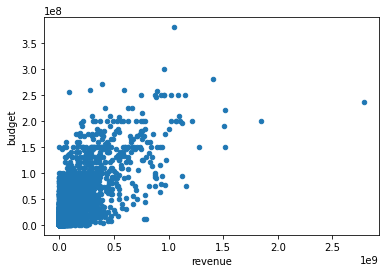

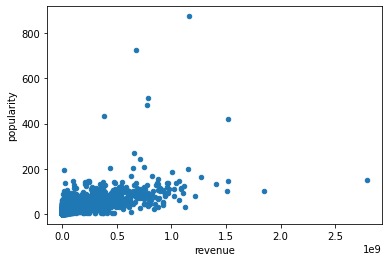

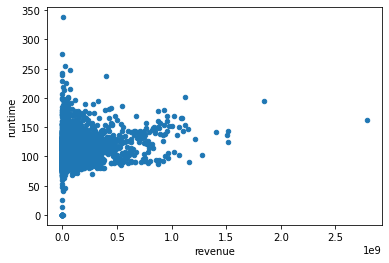

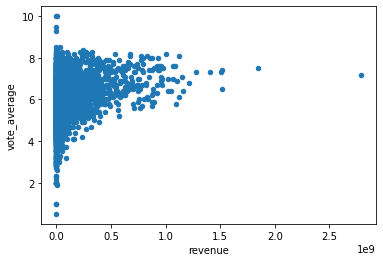

In [ ]:
movies_df.plot.scatter(x='revenue',y='budget');
movies_df.plot.scatter(x='revenue',y='popularity');
movies_df.plot.scatter(x='revenue',y='runtime');
movies_df.plot.scatter(x='revenue',y='vote_average');

In [ ]:
movies_df['Profit'] = movies_df['revenue'] - movies_df['budget']

Correlation Between Popularity And Profit :  0.6042142501821917


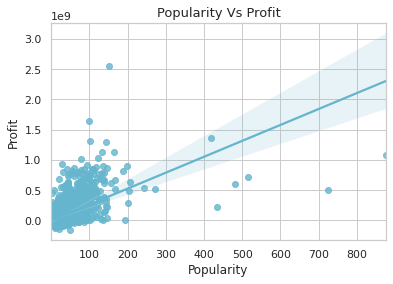

In [ ]:
ax = sns.regplot(x=movies_df['popularity'],y=movies_df['Profit'],color='c')

#setup the title and the labels of the scatter plot.
ax.set_title("Popularity Vs Profit",fontsize=13)
ax.set_xlabel("Popularity",fontsize=12)
ax.set_ylabel("Profit",fontsize=12)

#setup the figure size.
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")

#find the correlation between them.
print("Correlation Between Popularity And Profit : ",data_corr.loc['popularity','Profit'])


In [ ]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

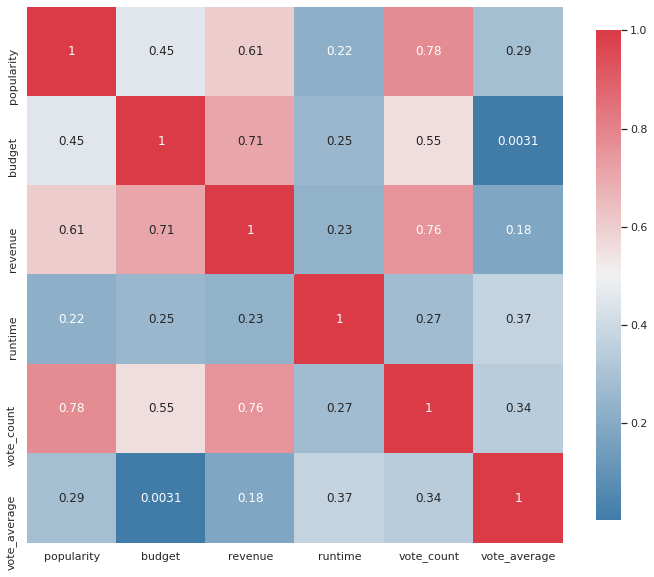

In [ ]:
plot_correlation_map(movies_df[['popularity','budget','revenue','runtime','vote_count','vote_average']])

In [ ]:
tmdb_df.columns

Index(['id', 'tittle', 'cast', 'crew', 'budget', 'genres', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
# drop duplicate columns
tmdb_df.drop(['original_title','tittle'], axis=1, inplace=True)
tmdb_df.reset_index(drop=True, inplace=True)

In [ ]:
# Check duplicates
# get duplicated row
duplicate_rows = tmdb_df[tmdb_df.applymap(lambda x: x[0] if isinstance(x, list) else x).duplicated(tmdb_df.columns)]
duplicate_rows


,id,cast,crew,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count


In [ ]:
tmdb_df.head()

,id,cast,crew,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124


In [ ]:
# Handle json data
json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages', 'cast', 'crew']
for col in json_columns:
    tmdb_df[col] = tmdb_df[col].apply(json.loads)

In [ ]:
# extract genres
tmdb_df['genres'] = [[genre['name'] for genre in movie] for movie in tmdb_df['genres']]
tmdb_df['genres'].head()

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genres, dtype: object

In [ ]:
# extract director
def get_director(crew_data):
    director = ''
    for crew in crew_data:
        if crew['job'] == 'Director':
            director = crew['name']
            break
        else:
            pass
    return director


In [ ]:
# calculate profit
def get_profit(budget, revenue):
    profit = revenue - budget
    return profit

In [ ]:
# deal with meaningless value
for genre in tmdb_df['genres']:
    if genre == []:
        genre.append('Unknown')

In [ ]:
tmdb_df['director'] = tmdb_df['crew'].apply(get_director)

In [ ]:
tmdb_df['profit'] = tmdb_df.apply(lambda row: get_profit(row['budget'], row['revenue']), axis=1)

In [ ]:
# Extract year from release date
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'])
tmdb_df['year'] = tmdb_df['release_date'].dt.year
tmdb_df['year'] = tmdb_df['year'].fillna(0).astype(int)

In [ ]:
# use data after 2000
tmdb_df = tmdb_df[tmdb_df['year'] >= 2000]

In [ ]:
tmdb_df.head()

,id,cast,crew,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,director,profit,year
0,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Avatar,7.2,11800,James Cameron,2550965087,2009
1,285,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[Adventure, Fantasy, Action]","[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,Gore Verbinski,661000000,2007
2,206647,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[Action, Adventure, Crime]","[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,Spectre,6.3,4466,Sam Mendes,635674609,2015
3,49026,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[Action, Crime, Drama, Thriller]","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Dark Knight Rises,7.6,9106,Christopher Nolan,834939099,2012
4,49529,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[Action, Adventure, Science Fiction]","[{'id': 818, 'name': 'based on novel'}, {'id':...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,John Carter,6.1,2124,Andrew Stanton,24139100,2012


In [ ]:
tmdb_df.shape

(3494, 22)

In [ ]:

from collections import defaultdict
tmdb_df.reset_index(inplace=True, drop=True)
genres = defaultdict(int)
for row in tmdb_df['genres']:
    for col in row:
        genres[col] += 1
movies_by_genres = pd.DataFrame(0, index = genres.keys(), columns=['profit', 'score'])
for i in range(len(tmdb_df)):
    for g in tmdb_df.genres[i]:
        movies_by_genres.loc[g, 'profit'] += tmdb_df.profit[i]
        movies_by_genres.loc[g, 'score'] += tmdb_df.vote_average[i]

movies_by_genres = movies_by_genres.div(list(genres.values()), axis=0)

In [ ]:
movies_by_genres.head()

,profit,score
Action,1.009999e+08,5.923768
Adventure,1.682701e+08,6.113383
Fantasy,1.623900e+08,6.062116
Science Fiction,1.176655e+08,5.957224
Crime,3.666650e+07,6.161350


In [ ]:
# normalize profit and score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(movies_by_genres) 
movies_by_genres.loc[:,:] = scaled_values

In [ ]:
movies_by_genres.head()

,profit,score
Action,0.603323,0.837664
Adventure,1.000000,0.883719
Fantasy,0.965326,0.871267
Science Fiction,0.701597,0.845790
Crime,0.223964,0.895370


In [ ]:
# extract four main actors
tmdb_df['actors'] = [[cast['name'] for cast in movie[0:4]] for movie in tmdb_df['cast']]
movies_noani = tmdb_df[~tmdb_df.genres.str.contains('Animation', regex=False)].reset_index(drop='True')

In [ ]:

actors = defaultdict(int)
for row in movies_noani['actors']:
    for col in row:
        actors[col] += 1


movies_by_actors = pd.DataFrame(0, index=actors.keys(), columns=['profit', 'score'])
r4 = [0.4, 0.3, 0.2, 0.1]
r3 = [0.4, 0.3, 0.3]
r2 = [0.6, 0.4]
r1 = [1]
r = [r1, r2, r3, r4]
for i in range(len(movies_noani)):
    actorlist = movies_noani.actors[i][0:4]
    for j in range(len(actorlist)):
        movies_by_actors.loc[actorlist[j], 'profit'] += movies_noani.profit[i] * r[len(actorlist)-1][j]
        movies_by_actors.loc[actorlist[j], 'score'] += movies_noani.vote_average[i]
movies_by_actors = movies_by_actors.div(list(actors.values()), axis=0)


In [ ]:
movies_by_actors.head() 

,profit,score
Sam Worthington,1.952864e+08,5.983333
Zoe Saldana,9.477030e+07,6.481818
Sigourney Weaver,4.124334e+07,5.983333
Stephen Lang,7.928869e+07,6.000000
Johnny Depp,7.889644e+07,6.450000


In [ ]:
tmdb_df.vote_average.mean()

5.982312535775608

In [ ]:
data = pd.DataFrame()
threshold = (tmdb_df.vote_average.mean() + 0.2) 
data['nice'] = tmdb_df['vote_average'].apply(lambda s: 1 if s >= threshold else 0)

In [ ]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
labels = ['Nice','Bad']
values = data['nice'].value_counts().tolist()
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.show()

In [ ]:
genre_list = movies_by_genres.index.tolist()
for genre in genre_list:
    data[genre] = tmdb_df['genres'].map(lambda s: 1 if genre in str(s) else 0)

director_list = score_by_director.index.tolist()
for director in director_list:
    data[director] = tmdb_df['director'].map(lambda s: 1 if director in str(s) else 0)

actor_list = movies_by_actors.index.tolist()
for actor in actor_list:
    data[actor] = tmdb_df['actors'].map(lambda s: 1 if actor in str(s) else 0)

In [ ]:
data.head()

,nice,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Horror,Romance,Mystery,History,War,Music,Documentary,Foreign,TV Movie,Unknown,Aaron Hann,Aaron Schneider,Adam Brooks,Adam Carolla,Adam Goldberg,Adam Green,Adam Jay Epstein,Adam McKay,Adam Rapp,Adam Rifkin,Adam Shankman,Adrian Lyne,Adrienne Shelly,Agnieszka Holland,Agnieszka Wojtowicz-Vosloo,Agustín Díaz Yanes,Aki Kaurismäki,Akiva Goldsman,...,Kelly Blatz,Brittany Curran,Gage Golightly,Rhett Wilkins,Louis Brooke,Allan Bryan Weku,Judy Gichohi,Kelly Gichohi,Zoe Lister-Jones,Julie White,Andrea Martin,Sophie Merkley,Béatrice Dalle,Jeanne Balibar,Nargess Mamizadeh,Maryiam Palvin Almani,Mojgan Faramarzi,Elham Saboktakin,Michael Parle,Emma Eliza Regan,Patrick O'Donnell,Kreeta Taponen,Tony Sancho,Michael Cortez,Donato Cruz,Felipe Camacho,Sasha Ramos,Erin Cline,Emily Rogers,Anthony Rutowicz,David Sullivan,Casey Gooden,Anand Upadhyaya,Marsha Dietlein,Crystal Lowe,Geoff Gustafson,Daniel Henney,Eliza Coupe,Alan Ruck,Corey Feldman
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X = data.loc[:,'Action':]
y = data.loc[:,'nice']
# split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

**KNN classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors= 60 )
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_evaluation = cross_val_score(knn, X, y, cv=10)
print('The accuracy of the KNN:')
print(knn_evaluation.mean())

The accuracy of the KNN:
0.5455038886614817


In [ ]:
print(classification_report(y_test, knn_y_pred, target_names=classes))

              precision    recall  f1-score   support

         bad       0.51      0.95      0.66       438
        nice       0.59      0.07      0.12       436

    accuracy                           0.51       874
   macro avg       0.55      0.51      0.39       874
weighted avg       0.55      0.51      0.39       874



**Gradiant Boosting classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier  

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)
gb_evaluation = cross_val_score(gb, X, y, cv=10)
print('The accuracy of the GB:')
print(gb_evaluation.mean())

The accuracy of the GB:
0.6602898076135897


In [ ]:
print(classification_report(y_test, gb_y_pred, target_names=classes))

              precision    recall  f1-score   support

         bad       0.70      0.61      0.65       438
        nice       0.65      0.74      0.69       436

    accuracy                           0.67       874
   macro avg       0.68      0.67      0.67       874
weighted avg       0.68      0.67      0.67       874



**Random Forrest**

In [ ]:
# build model to predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
Rfclf = RandomForestClassifier(n_estimators=200)
Rfclf.fit(X_train, y_train)
rf_y_pred = Rfclf.predict(X_test)

In [ ]:
# Evaluate our model through k-fold cross validation ('CV = 10') 
from sklearn.model_selection import cross_val_score
rf_evaluation = cross_val_score(Rfclf, X, y, cv=10)
print('The accuracy of the model:')
print(rf_evaluation.mean())

The accuracy of the model:
0.6628497748669668


In [ ]:
# Defining the 'plot_confusion_matrix' function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[301 137]
 [151 285]]


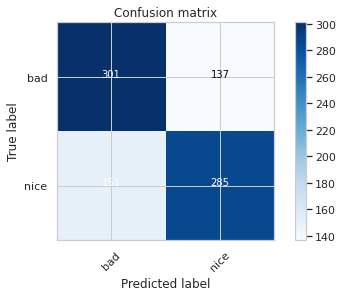

In [ ]:
# Evaluate our result
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools 
results = confusion_matrix(y_test, rf_y_pred)
%matplotlib inline
plot_confusion_matrix(results, classes = ['bad','nice'])

In [ ]:
from sklearn.metrics import classification_report
# Specify the target classes
classes = ["bad", "nice"]
print(classification_report(y_test, rf_y_pred, target_names=classes))

              precision    recall  f1-score   support

         bad       0.67      0.69      0.68       438
        nice       0.68      0.65      0.66       436

    accuracy                           0.67       874
   macro avg       0.67      0.67      0.67       874
weighted avg       0.67      0.67      0.67       874



**SVC**

In [ ]:
from sklearn.svm import SVC
svcclf = SVC()
svcclf.fit(X_train, y_train)
svc_y_pred = svcclf.predict(X_test)
svc_evaluation = cross_val_score(svcclf, X, y, cv=10)
print('The accuracy of SVC model:')
print(svc_evaluation.mean())

The accuracy of SVC model:
0.673724109701187


Confusion matrix, without normalization
[[266 172]
 [107 329]]
              precision    recall  f1-score   support

         bad       0.71      0.61      0.66       438
        nice       0.66      0.75      0.70       436

    accuracy                           0.68       874
   macro avg       0.68      0.68      0.68       874
weighted avg       0.68      0.68      0.68       874



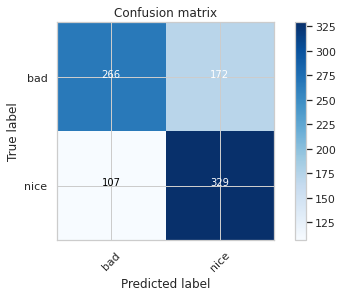

In [ ]:
results = confusion_matrix(y_test, svc_y_pred)
%matplotlib inline
plot_confusion_matrix(results, classes = ['bad','nice'])
print(classification_report(y_test, svc_y_pred, target_names=classes))

In [ ]:
cv_means = []
cv_means.append(knn_evaluation.mean())
cv_means.append(gb_evaluation.mean())
cv_means.append(rf_evaluation.mean())
cv_means.append(svc_evaluation.mean())

In [ ]:
cv_std = []
cv_std.append(knn_evaluation.std())
cv_std.append(gb_evaluation.std())
cv_std.append(rf_evaluation.std())
cv_std.append(svc_evaluation.std())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



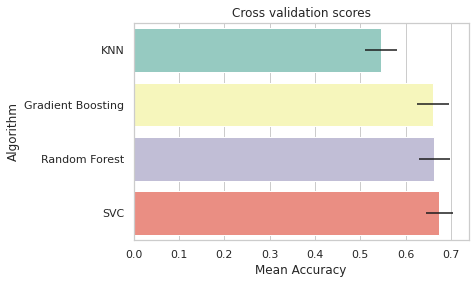

In [ ]:
res1 = pd.DataFrame({"ACC":cv_means,"Std":cv_std,"Algorithm":["KNN","Gradient Boosting","Random Forest","SVC"]})
res1["Type"]= "CrossValid"
g = sns.barplot("ACC","Algorithm",data = res1, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# **Classifier with the lowest (RMSE)**

In [ ]:
from sklearn import linear_model as lm, metrics, tree, ensemble, model_selection as ms, feature_selection, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

%matplotlib inline

pd.options.mode.chained_assignment = None 

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

**Preprocessing**

In [ ]:
#import datasets
credits = pd.read_csv(path + 'Dataset/credits.csv')
# movies_df = pd.read_csv(path + 'Dataset/tmdb_5000_movies.csv')

In [ ]:
credits.cast[0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

In [ ]:
all_casts = []
all_crews = []
for i in range(credits.shape[0]):
    cast = eval(credits['cast'][i])
    for x in cast:
        x['movie_id'] = credits['id'][i]
    crew = eval(credits['crew'][i])
    for x in crew:
        x['movie_id'] = credits['id'][i]
    all_casts.extend(cast)
    all_crews.extend(crew)

all_casts = pd.DataFrame(all_casts)
all_crews = pd.DataFrame(all_crews)

In [ ]:
all_casts.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path,movie_id
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg,862
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg,862
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg,862
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg,862
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg,862


In [ ]:
all_crews.head()

,credit_id,department,gender,id,job,name,profile_path,movie_id
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg,862
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg,862
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg,862
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg,862
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg,862


In [ ]:
cast = all_casts[['name', 'order', 'gender', 'movie_id']]
cast.head()

,name,order,gender,movie_id
0,Tom Hanks,0,2,862
1,Tim Allen,1,2,862
2,Don Rickles,2,2,862
3,Jim Varney,3,2,862
4,Wallace Shawn,4,2,862


In [ ]:
crew = all_crews[['name', 'job', 'gender', 'movie_id']]
crew.head()

,name,job,gender,movie_id
0,John Lasseter,Director,2,862
1,Joss Whedon,Screenplay,2,862
2,Andrew Stanton,Screenplay,2,862
3,Joel Cohen,Screenplay,2,862
4,Alec Sokolow,Screenplay,0,862


In [ ]:
movies_metadata = pd.read_csv(path + "Dataset/movies_metadata.csv", low_memory = False)
movies_metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [ ]:
metadata = movies_metadata[['title', 'id', 'budget',  'revenue', 'runtime', 'vote_average', 
                            'vote_count', 'belongs_to_collection']].copy()

metadata['belongs_to_collection'].fillna('0', inplace = True)
collection = metadata[['belongs_to_collection']].copy()
collection[collection != '0'] = '1'
metadata['belongs_to_collection'] = collection

In [ ]:
metadata.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection
0,Toy Story,862,30000000,373554033.0,81.0,7.7,5415.0,1
1,Jumanji,8844,65000000,262797249.0,104.0,6.9,2413.0,0
2,Grumpier Old Men,15602,0,0.0,101.0,6.5,92.0,1
3,Waiting to Exhale,31357,16000000,81452156.0,127.0,6.1,34.0,0
4,Father of the Bride Part II,11862,0,76578911.0,106.0,5.7,173.0,1


In [ ]:
g = movies_metadata[['id', 'genres']]
genlist = []

for i in range(g.shape[0]):
    gen = eval(g['genres'][i])
    for each in gen:
        each['id'] = g['id'][i]
    genlist.extend(gen)
genre = pd.DataFrame(genlist)

In [ ]:
genre = genre.rename(columns={'name':'genre'})
genre = genre[['id', 'genre']]
genre['tmp'] = 1
genre.head()

,id,genre,tmp
0,862,Animation,1
1,862,Comedy,1
2,862,Family,1
3,8844,Adventure,1
4,8844,Fantasy,1


In [ ]:
pivot = genre.pivot_table('tmp', 'id', 'genre', fill_value=0)
flattened = pd.DataFrame(pivot.to_records())
metadata_genre = pd.merge(metadata, flattened, on = 'id', how = 'left')
metadata_genre.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western
0,Toy Story,862,30000000,373554033.0,81.0,7.7,5415.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,8844,65000000,262797249.0,104.0,6.9,2413.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,15602,0,0.0,101.0,6.5,92.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,31357,16000000,81452156.0,127.0,6.1,34.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,11862,0,76578911.0,106.0,5.7,173.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lead = cast[cast['order'] == 0]
lead = lead[['movie_id', 'name']]
lead = lead.rename(columns={'movie_id':'id'})
lead = lead.rename(columns={'name':'lead'})
lead.head(2)

,id,lead
0,862,Tom Hanks
13,8844,Robin Williams


In [ ]:
print("Number of rows before dropping those with null values:",len(metadata_genre))
metadata_genre.dropna(inplace = True)
print("Number of rows after dropping those with null values:",len(metadata_genre))

Number of rows before dropping those with null values: 45466
Number of rows after dropping those with null values: 42839


In [ ]:
metadata_genre['id'] = metadata_genre['id'].astype('int64')
metadata_genre_lead = pd.merge(metadata_genre, lead, on = 'id', how = 'left')

In [ ]:
supporting = cast[cast['order'] == 1]
supporting = supporting[['movie_id', 'name']]
supporting = supporting.rename(columns={'movie_id':'id'})
supporting = supporting.rename(columns={'name':'supporting'})
metadata_genre_lead_supporting = pd.merge(metadata_genre_lead, supporting, on = 'id', how = 'left')

In [ ]:
metadata_genre_lead_supporting.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western,lead,supporting
0,Toy Story,862,30000000,373554033.0,81.0,7.7,5415.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tom Hanks,Tim Allen
1,Jumanji,8844,65000000,262797249.0,104.0,6.9,2413.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Robin Williams,Jonathan Hyde
2,Grumpier Old Men,15602,0,0.0,101.0,6.5,92.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Walter Matthau,Jack Lemmon
3,Waiting to Exhale,31357,16000000,81452156.0,127.0,6.1,34.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Whitney Houston,Angela Bassett
4,Father of the Bride Part II,11862,0,76578911.0,106.0,5.7,173.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Steve Martin,Diane Keaton


In [ ]:
director = crew[crew['job'] == 'Director']
director = director[['movie_id', 'name']]
director = director.rename(columns={'movie_id':'id', 'name':'director'})

In [ ]:
dataset = pd.merge(metadata_genre_lead_supporting, director, on = 'id', how = 'left')
print("Number of rows before dropping those with null values:",len(dataset))
dataset.dropna(inplace = True)
print("Number of rows after dropping those with null values:",len(dataset))

Number of rows before dropping those with null values: 47632
Number of rows after dropping those with null values: 37580


In [ ]:
final_dataset = dataset.loc[(dataset['budget'] != '0') & (dataset['revenue'] != 0)]
final_dataset['budget'] = final_dataset['budget'].astype('float64')
final_dataset['belongs_to_collection'] = final_dataset['belongs_to_collection'].astype('int64')
final_dataset = final_dataset[final_dataset['vote_count'] > 50]

In [ ]:
final_dataset.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western,lead,supporting,director
0,Toy Story,862,30000000.0,373554033.0,81.0,7.7,5415.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tom Hanks,Tim Allen,John Lasseter
1,Jumanji,8844,65000000.0,262797249.0,104.0,6.9,2413.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Robin Williams,Jonathan Hyde,Joe Johnston
5,Heat,949,60000000.0,187436818.0,170.0,7.7,1886.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Al Pacino,Robert De Niro,Michael Mann
8,Sudden Death,9091,35000000.0,64350171.0,106.0,5.5,174.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Jean-Claude Van Damme,Powers Boothe,Peter Hyams
9,GoldenEye,710,58000000.0,352194034.0,130.0,6.6,1194.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Pierce Brosnan,Sean Bean,Martin Campbell


In [ ]:
print("Before duplicates dropped:", len(final_dataset))
final_dataset.drop_duplicates(inplace=True)
print("After duplicates dropped:", len(final_dataset))

Before duplicates dropped: 4676
After duplicates dropped: 4632


In [ ]:
final_dataset['dir_count'] = final_dataset.groupby('director')['director'].transform('count')

In [ ]:
final_dataset.dir_count

0         5
1         7
5        10
8        10
9         8
         ..
46817    10
47000    13
47184     2
47314     2
47339     1
Name: dir_count, Length: 4632, dtype: int64

In [ ]:
final_dataset['dir_count'] = final_dataset.groupby('director')['director'].transform('count')
final_dataset = final_dataset[final_dataset["dir_count"] >= 5]
final_dataset_wo_dir = final_dataset.drop("director", axis=1).drop_duplicates(keep="first")
# directors = final_dataset[["id", "director"]]

In [ ]:
final_dataset_wo_dir.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western,lead,supporting,dir_count
0,Toy Story,862,30000000.0,373554033.0,81.0,7.7,5415.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tom Hanks,Tim Allen,5
1,Jumanji,8844,65000000.0,262797249.0,104.0,6.9,2413.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Robin Williams,Jonathan Hyde,7
5,Heat,949,60000000.0,187436818.0,170.0,7.7,1886.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Al Pacino,Robert De Niro,10
8,Sudden Death,9091,35000000.0,64350171.0,106.0,5.5,174.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Jean-Claude Van Damme,Powers Boothe,10
9,GoldenEye,710,58000000.0,352194034.0,130.0,6.6,1194.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Pierce Brosnan,Sean Bean,8


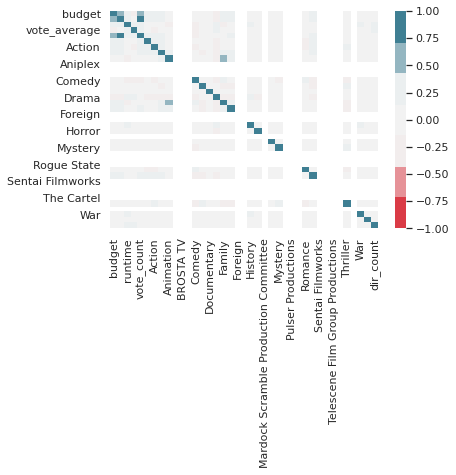

In [ ]:
sns.heatmap(final_dataset_wo_dir.drop(['title', 'id'], axis=1).corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

In [ ]:
dummies = pd.get_dummies(final_dataset_wo_dir, columns=['lead', 'supporting'], drop_first=True)
dummies.head()

,title,id,budget,revenue,runtime,vote_average,vote_count,belongs_to_collection,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western,...,supporting_Vin Diesel,supporting_Vince Vaughn,supporting_Vincent Cassel,supporting_Vincent D'Onofrio,supporting_Vincent Piazza,supporting_Ving Rhames,supporting_Virginia Cherrill,supporting_Virginia Madsen,supporting_Vladimir Kulich,supporting_Vladimir Menshov,supporting_Walter Huston,supporting_Wayne Newton,supporting_Wendy Raquel Robinson,supporting_Wentworth Miller,supporting_Wesley Snipes,supporting_Whitney Houston,supporting_Will Ferrell,supporting_Will Forte,supporting_Will Sasso,supporting_Will Smith,supporting_Willem Dafoe,supporting_William Atherton,supporting_William Baldwin,supporting_William Forsythe,supporting_William H. Macy,supporting_William Holden,supporting_William Hurt,supporting_Winona Ryder,supporting_Woody Harrelson,supporting_Yaphet Kotto,supporting_Yasiin Bey,supporting_Yuriko Ishida,supporting_Zac Efron,supporting_Zach Galifianakis,supporting_Zachary Quinto,supporting_Zoe Saldana,supporting_Zooey Deschanel,supporting_Zoë Bell,supporting_Zuleikha Robinson,supporting_Óscar Jaenada
0,Toy Story,862,30000000.0,373554033.0,81.0,7.7,5415.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jumanji,8844,65000000.0,262797249.0,104.0,6.9,2413.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Heat,949,60000000.0,187436818.0,170.0,7.7,1886.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Sudden Death,9091,35000000.0,64350171.0,106.0,5.5,174.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,GoldenEye,710,58000000.0,352194034.0,130.0,6.6,1194.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dummies.drop(["id", "title"], axis=1, inplace=True)
final = dummies.copy()
final.drop_duplicates(inplace=True)

**Model Creation** 

In [ ]:
X = final.drop(["vote_average"], axis=1)
y = final.vote_average


In [ ]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=42)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
print("Length of training sets:",len(X_train), len(X_test))
print("Length of testing sets:",len(y_train), len(y_test))

Length of training sets: 1320 567
Length of testing sets: 1320 567


In [ ]:
y_pred_mean = [y_train.mean()] * len(y_test)

print("Baseline score RMSE: ",'{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))))

Baseline score RMSE:  0.78


In [ ]:
# Function to return simple model metrics
def get_model_metrics(X_train, y_train, X_test, y_test, model, parametric=True):
    sklearn_pca = PCA(n_components=500,svd_solver="full")
    X_trainn = sklearn_pca.fit_transform(X_train)
    X_tesst = sklearn_pca.fit_transform(X_test)
    model.fit(X_trainn, y_train)
    train_pred = np.around(model.predict(X_trainn),1)
    test_pred = np.around(model.predict(X_tesst),1)
    
    print('Training score', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, train_pred))))
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, test_pred))))
    cv_scores = -ms.cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('Cross-validated RMSEs:', np.sqrt(cv_scores))
    print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.sqrt(np.mean(cv_scores))))
    
    if parametric == True:
        print(pd.DataFrame(list(zip(X_train.columns, model.coef_, abs(model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        print(pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return model
 


In [ ]:
# Function to return regularised model metrics
def regularised_model_metrics(X_train, y_train, X_test, y_test, model, grid_params, parametric=True):
    gridsearch = GridSearchCV(model,
                              grid_params,
                              n_jobs=-1, cv=5, verbose=1, error_score='neg_mean_squared_error')
    sklearn_pca = PCA(n_components=500,svd_solver="full")
    X_trainn = sklearn_pca.fit_transform(X_train)
    X_tesst = sklearn_pca.fit_transform(X_test)
    gridsearch.fit(X_trainn, y_train)
    print('Best parameters:', gridsearch.best_params_)
    print('Cross-validated score on test data:', '{0:0.2f}'.format(abs(gridsearch.best_score_)))
    best_model = gridsearch.best_estimator_
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, best_model.predict(X_tesst)))))
    
    if parametric == True:
        print(pd.DataFrame(list(zip(X_train.columns, best_model.coef_, abs(best_model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        print(pd.DataFrame(list(zip(X_train.columns, best_model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return best_model

**Linear Regression**

In [ ]:
lm_simple = get_model_metrics(X_train, y_train, X_test, y_test, lm.LinearRegression())
lm_simple

Training score 0.46
Testing RMSE: 1.22
Cross-validated RMSEs: [5.26095231e+13 7.18885137e+13 1.20734270e+14 6.15916473e+13
 9.02966495e+13]
Mean cross-validated RMSE: 83017468193427.81
                                  Feature      Coef  Abs Coef
2                                 runtime -0.127445  0.127445
4                   belongs_to_collection  0.114639  0.114639
21  Mardock Scramble Production Committee  0.096383  0.096383
22                                  Music  0.092569  0.092569
19                                History  0.091661  0.091661
11                                 Comedy -0.086214  0.086214
1                                 revenue -0.083291  0.083291
13                            Documentary -0.079448  0.079448
16                                Fantasy -0.074974  0.074974
14                                  Drama  0.072061  0.072061


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
ridge = lm.Ridge()
list(ridge.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'max_iter',
 'normalize',
 'random_state',
 'solver',
 'tol']

In [ ]:
ridge_params = {'alpha': np.logspace(-10, 10, 10),
               'fit_intercept': [True, False],
               'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ridge_model = regularised_model_metrics(X_train, y_train, X_test, y_test, ridge, ridge_params)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:  4.0min


Best parameters: {'alpha': 2154.4346900318865, 'fit_intercept': True, 'solver': 'auto'}
Cross-validated score on test data: 0.25
Testing RMSE: 0.97
                                  Feature      Coef  Abs Coef
2                                 runtime -0.086816  0.086816
4                   belongs_to_collection  0.073890  0.073890
1                                 revenue -0.060108  0.060108
21  Mardock Scramble Production Committee  0.054519  0.054519
19                                History  0.052304  0.052304
22                                  Music  0.052161  0.052161
11                                 Comedy -0.051746  0.051746
13                            Documentary -0.046923  0.046923
16                                Fantasy -0.043622  0.043622
14                                  Drama  0.042552  0.042552


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  4.2min finished


In [ ]:
lasso = lm.Lasso()
list(lasso.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'max_iter',
 'normalize',
 'positive',
 'precompute',
 'random_state',
 'selection',
 'tol',
 'warm_start']

In [ ]:
lasso_params = {'alpha': np.logspace(-10, 10, 10),
               'fit_intercept': [True, False]}

lasso_model = regularised_model_metrics(X_train, y_train, X_test, y_test, lasso, lasso_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


Best parameters: {'alpha': 0.07742636826811278, 'fit_intercept': True}
Cross-validated score on test data: 0.31
Testing RMSE: 0.95
                                  Feature      Coef  Abs Coef
2                                 runtime -0.105244  0.105244
4                   belongs_to_collection  0.088478  0.088478
1                                 revenue -0.064995  0.064995
21  Mardock Scramble Production Committee  0.059957  0.059957
19                                History  0.055965  0.055965
22                                  Music  0.055819  0.055819
11                                 Comedy -0.054615  0.054615
13                            Documentary -0.046565  0.046565
16                                Fantasy -0.040879  0.040879
14                                  Drama  0.039164  0.039164


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


In [ ]:
elastic = lm.ElasticNet()
list(elastic.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'l1_ratio',
 'max_iter',
 'normalize',
 'positive',
 'precompute',
 'random_state',
 'selection',
 'tol',
 'warm_start']

In [ ]:
elastic_params = {'alpha': np.logspace(-10, 10, 10),
                 'l1_ratio': np.linspace(0.05, 0.95, 10),
                 'fit_intercept': [True, False]}

elastic_model = regularised_model_metrics(X_train, y_train, X_test, y_test, elastic, 
                                          elastic_params)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:  2.3min


Best parameters: {'alpha': 0.07742636826811278, 'fit_intercept': True, 'l1_ratio': 0.35}
Cross-validated score on test data: 0.36
Testing RMSE: 1.08
                                  Feature      Coef  Abs Coef
2                                 runtime -0.117972  0.117972
4                   belongs_to_collection  0.103719  0.103719
21  Mardock Scramble Production Committee  0.081700  0.081700
22                                  Music  0.077847  0.077847
19                                History  0.077372  0.077372
1                                 revenue -0.075984  0.075984
11                                 Comedy -0.073642  0.073642
13                            Documentary -0.066518  0.066518
16                                Fantasy -0.061674  0.061674
14                                  Drama  0.059279  0.059279


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


**Tree Models(Decision Tree,Random Forrest Regressor,BaggingRegressor)**

In [ ]:
dt = get_model_metrics(X_train, y_train, X_test, y_test, tree.DecisionTreeRegressor(), 
                       parametric=False)
dt

Training score 0.00
Testing RMSE: 1.03
Cross-validated RMSEs: [0.69068477 0.67661143 0.78417105 0.68700051 0.71713339]
Mean cross-validated RMSE: 0.71
                                   Feature  Importance
2                                  runtime    0.090348
21   Mardock Scramble Production Committee    0.060137
1                                  revenue    0.045301
45                          lead_Al Pacino    0.045295
5                                   Action    0.027483
295                 lead_Hayden Panettiere    0.023266
14                                   Drama    0.020163
78                    lead_Asa Butterfield    0.017219
371                     lead_Jeremy Renner    0.015110
4                    belongs_to_collection    0.014159


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
rf = get_model_metrics(X_train, y_train, X_test, y_test, ensemble.RandomForestRegressor(), 
                       parametric=False)
rf

Training score 0.25
Testing RMSE: 0.82
Cross-validated RMSEs: [0.50196921 0.53610801 0.56758758 0.50359142 0.58526882]
Mean cross-validated RMSE: 0.54
                                  Feature  Importance
2                                 runtime    0.090204
1                                 revenue    0.043227
4                   belongs_to_collection    0.034896
21  Mardock Scramble Production Committee    0.029950
22                                  Music    0.020532
23                                Mystery    0.016819
11                                 Comedy    0.013113
3                              vote_count    0.012248
45                         lead_Al Pacino    0.012174
5                                  Action    0.010982


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rrf = ensemble.RandomForestRegressor()
list(rrf.get_params())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [ ]:
rrf_params = {'bootstrap': [True, False],
             'max_depth': np.linspace(5, 50, 5),
             'min_samples_split': np.linspace(0.01, 1, 5),
             'n_estimators': [40, 50, 60]}

rrf_model = regularised_model_metrics(X_train, y_train, X_test, y_test, rrf, rrf_params,
                                     parametric=False)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 47.6min finished


Best parameters: {'bootstrap': True, 'max_depth': 27.5, 'min_samples_split': 0.01, 'n_estimators': 50}
Cross-validated score on test data: 0.30
Testing RMSE: 0.84
                                  Feature  Importance
2                                 runtime    0.098773
1                                 revenue    0.046596
4                   belongs_to_collection    0.042793
21  Mardock Scramble Production Committee    0.035972
22                                  Music    0.028178
23                                Mystery    0.017176
19                                History    0.013408
16                                Fantasy    0.011642
11                                 Comedy    0.011217
5                                  Action    0.010824


In [ ]:
bagdt = ensemble.BaggingRegressor()
bagdt.fit(X_train, y_train)

print('Training RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, bagdt.predict(X_train)))))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, bagdt.predict(X_test)))))
cv_scores = -ms.cross_val_score(bagdt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('Cross-validated RMSEs:', cv_scores)
print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.mean(cv_scores)))

Training RMSE: 0.23
Testing RMSE: 0.56
Cross-validated RMSEs: [0.26898485 0.30866288 0.33906326 0.28317462 0.3537803 ]
Mean cross-validated RMSE: 0.31


**SVM**

In [ ]:
lin = svm.LinearSVR() 

lin_params = {
    'C': np.logspace(-3, 2, 5),
    'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
    'fit_intercept': [True,False],
    'max_iter': [1000]
}

lin_model = regularised_model_metrics(X_train, y_train, X_test, y_test, lin, lin_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Best parameters: {'C': 0.01778279410038923, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}
Cross-validated score on test data: 33.35
Testing RMSE: 1.23
                                  Feature      Coef  Abs Coef
2                                 runtime -0.126677  0.126677
4                   belongs_to_collection  0.113760  0.113760
21  Mardock Scramble Production Committee  0.095434  0.095434
22                                  Music  0.091643  0.091643
19                                History  0.090797  0.090797
11                                 Comedy -0.085473  0.085473
1                                 revenue -0.082882  0.082882
13                            Documentary -0.078726  0.078726
16                                Fantasy -0.074275  0.074275
14                                  Drama  0.071420  0.071420


In [ ]:
rbf = svm.SVR(kernel='rbf')

rbf_params = {
    'C': np.logspace(-3, 3, 5),
    'gamma': np.logspace(-4, 1, 5),
    'kernel': ['rbf']}

rbf = GridSearchCV(rbf, rbf_params, n_jobs=-1, cv=5, verbose=1, error_score='neg_mean_squared_error')
rbf.fit(X_train, y_train)
print('Best parameters:', rbf.best_params_)
print('Cross-validated Training RMSE:', '{0:0.2f}'.format(abs(rbf.best_score_)))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, rbf.best_estimator_.predict(X_test)))))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.1min finished


Best parameters: {'C': 31.622776601683793, 'gamma': 0.0001, 'kernel': 'rbf'}
Cross-validated Training RMSE: 0.25
Testing RMSE: 0.69


In [ ]:
poly = svm.SVR(kernel='poly')

poly_params = {
    'C': np.linspace(0.01, 0.2, 10),
    'gamma': np.logspace(-5, 2, 10),
    'degree': [2]}

poly = GridSearchCV(poly, poly_params, n_jobs=-1, cv=5, verbose=1, error_score='neg_mean_squared_error')
poly.fit(X_train, y_train)
print('Best parameters:', poly.best_params_)
print('Cross-validated Training RMSE:', '{0:0.2f}'.format(abs(poly.best_score_)))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, poly.best_estimator_.predict(X_test)))))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.2min finished


Best parameters: {'C': 0.09444444444444444, 'degree': 2, 'gamma': 0.0774263682681127}
Cross-validated Training RMSE: 0.07
Testing RMSE: 0.78


In [2]:
import seaborn as sn

In [19]:
compare = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/recommendation system/dataset/compare.csv")
compare.head()

,model,TMDB_rmse,50K_movielens,100k_movielens,Unnamed: 4,Unnamed: 5
0,LinearRegression,1.22,1.16,1.10,NaN,NaN
1,ridge,0.97,1.16,1.10,NaN,NaN
2,lasso,0.95,1.16,1.10,NaN,NaN
3,ElasticNet,1.08,1.15,1.10,NaN,NaN
4,Decision Tree,1.03,1.67,1.22,NaN,NaN


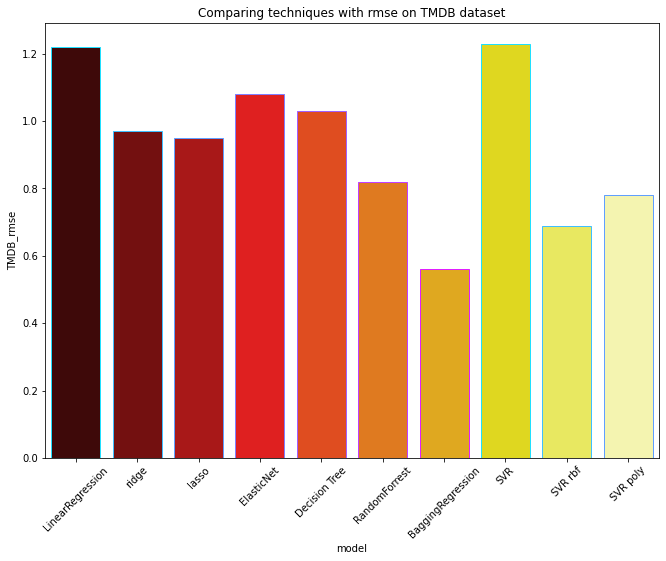

In [20]:
plt.subplots(figsize=(11,8))
sn.barplot(x="model", y="TMDB_rmse" ,data=compare,palette='hot',edgecolor=sn.color_palette('cool',7))
plt.xticks(rotation=45)
plt.title('Comparing techniques with rmse on TMDB dataset')
plt.show()


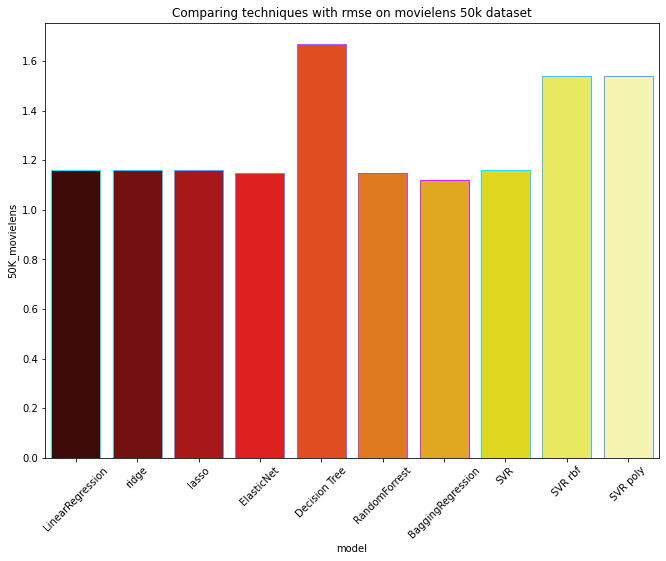

In [21]:
plt.subplots(figsize=(11,8))
sn.barplot(x="model", y="50K_movielens" ,data=compare,palette='hot',edgecolor=sn.color_palette('cool',7))
plt.xticks(rotation=45)
plt.title('Comparing techniques with rmse on movielens 50k dataset')
plt.show()

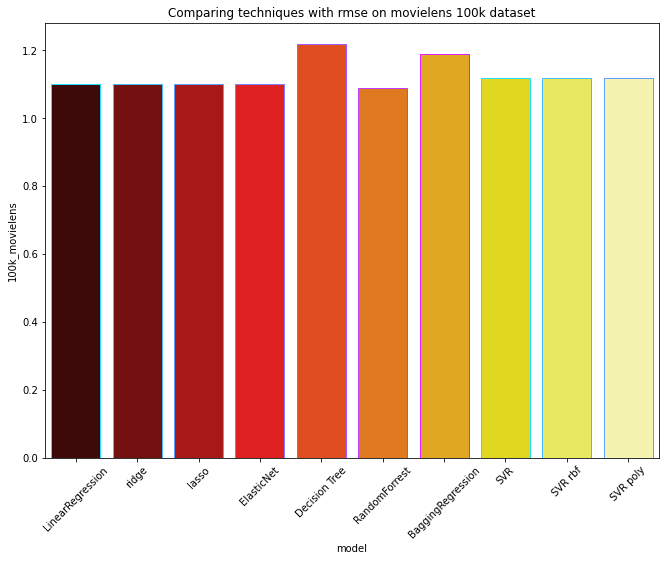

In [22]:
plt.subplots(figsize=(11,8))
sn.barplot(x="model", y="100k_movielens" ,data=compare,palette='hot',edgecolor=sn.color_palette('cool',7))
plt.xticks(rotation=45)
plt.title('Comparing techniques with rmse on movielens 100k dataset')
plt.show()

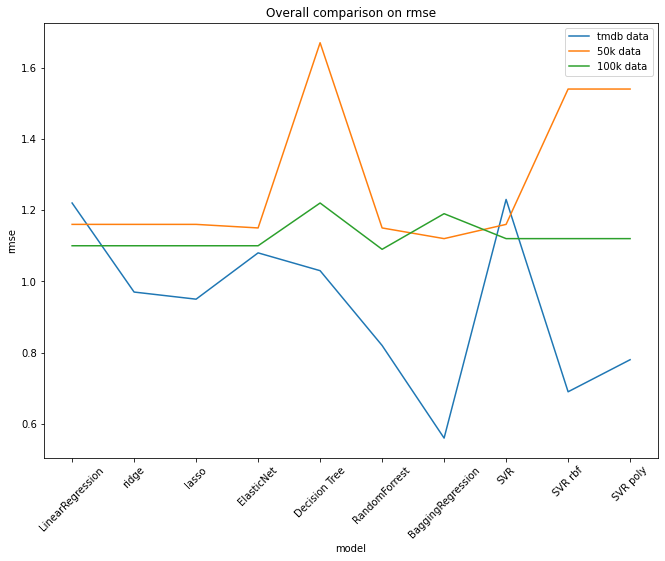

In [23]:
# create the time series plot
plt.subplots(figsize=(11,8))
sns.lineplot(x = "model", y = "TMDB_rmse", data = compare,label="tmdb data")
sns.lineplot(x = "model", y = "50K_movielens", data = compare,label="50k data")
sns.lineplot(x = "model", y = "100k_movielens", data = compare, label="100k data")
plt.xticks(rotation=45)
plt.ylabel("rmse")
plt.title('Overall comparison on rmse')
plt.show()
